Code from: https://www.kaggle.com/philschmidt/cervix-eda-model-selection

Import libraries and packages:

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2 # first I needed to run following command: sudo pip3 install opencv-python

%matplotlib inline
import plotly.offline as py # first I needed to run following command: pip install plotly
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from subprocess import check_output
from glob import glob
import os

Print files in current directory (gives you list of labels, since the images are organized by label directory!):

In [57]:
print(check_output(["ls", "sample_train_cervix_shapes"]).decode("utf8"))

Type1
Type2
Type3



Create dataframe where you have each image path, file type and label:

In [58]:
basepath = 'sample_train_cervix_shapes/'

all_cervix_images = []

for path in sorted(glob(basepath + "*")): # iterate through each directory (ie each type)
    cervix_type = path.split("/")[-1] # gives you the type (ie directory) of current instance
    cervix_images = sorted(glob(basepath + cervix_type + "/*")) # gives you all images in current directory,
        # in the following format: sample_train_cervix_shapes/Type1/image_number.jpg
    all_cervix_images = all_cervix_images + cervix_images # list of all of the images in same format as previous!
    
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,sample_train_cervix_shapes/Type1/191.jpg,jpg,Type1
1,sample_train_cervix_shapes/Type1/201.jpg,jpg,Type1
2,sample_train_cervix_shapes/Type1/205.jpg,jpg,Type1
3,sample_train_cervix_shapes/Type1/208.jpg,jpg,Type1
4,sample_train_cervix_shapes/Type1/215.jpg,jpg,Type1


Count how many images per label:

We have a total of 60 images in the whole dataset


Text(0.5, 0, 'training size fraction')

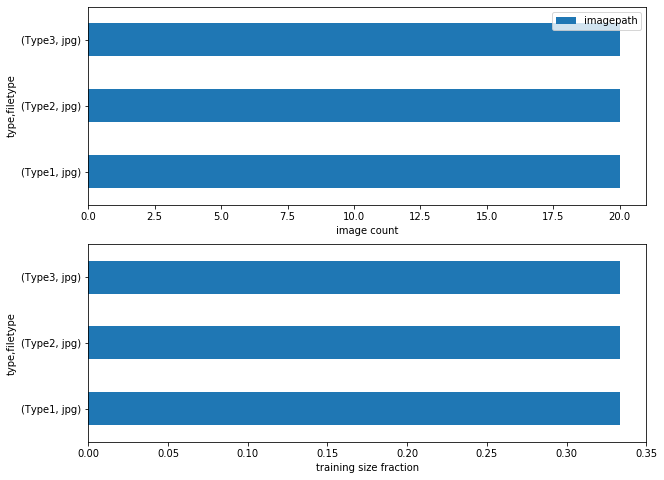

In [59]:
print('We have a total of {} images in the whole dataset'.format(all_cervix_images.shape[0]))
type_aggregation = all_cervix_images.groupby(['type', 'filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/all_cervix_images.shape[0], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

type_aggregation.plot.barh(ax=axes[0])
axes[0].set_xlabel("image count")
type_aggregation_p.plot.barh(ax=axes[1])
axes[1].set_xlabel("training size fraction")

Visualize each type of cervix:

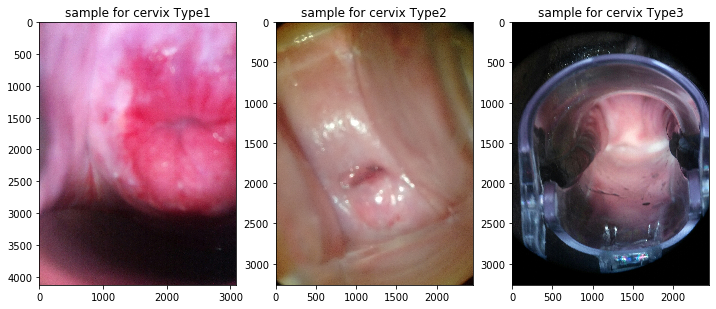

In [60]:
fig = plt.figure(figsize=(12,8))

i = 1
for t in all_cervix_images['type'].unique():
    ax = fig.add_subplot(1,3,i)
    i+=1
    f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.title('sample for cervix {}'.format(t))

Get the distribution of image dimensions by type, via df and barplots (note: all images have 3 channels since tehy are in RGB): 

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 3

/Users/nadiablostein/minic

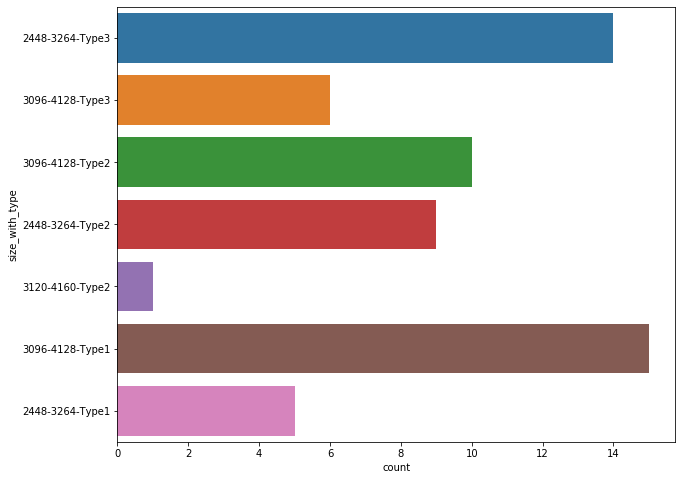

In [61]:
from collections import defaultdict

images = defaultdict(list)

for t in all_cervix_images['type'].unique():
    sample_counter = 0
    for _, row in all_cervix_images[all_cervix_images['type'] == t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = imread(row.imagepath)
            sample_counter +=1
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))
        if sample_counter > 35:
            break
dfs = []
for t in all_cervix_images['type'].unique():
    t_ = pd.DataFrame(
        {
            'nrows': list(map(lambda i: i.shape[0], images[t])),
            'ncols': list(map(lambda i: i.shape[1], images[t])),
            'nchans': list(map(lambda i: i.shape[2], images[t])),
            'type': t
        }
    )
    dfs.append(t_)

shapes_df = pd.concat(dfs, axis=0)
shapes_df_grouped = shapes_df.groupby(by=['nchans', 'ncols', 'nrows', 'type']).size().reset_index().sort_values(['type', 0], ascending=False)
# get the .csv file of size_by_type:
# shapes_df_grouped.to_csv("size_by_type_distribution.csv")

shapes_df_grouped['size_with_type'] = shapes_df_grouped.apply(lambda row: '{}-{}-{}'.format(row.ncols, row.nrows, row.type), axis=1)
shapes_df_grouped = shapes_df_grouped.set_index(shapes_df_grouped['size_with_type'].values)
shapes_df_grouped['count'] = shapes_df_grouped[[0]]

plt.figure(figsize=(10,8))
#shapes_df_grouped['count'].plot.barh(figsize=(10,8))
sns.barplot(x="count", y="size_with_type", data=shapes_df_grouped)

Function that returns the file path of the image in the format of "sample_train_cervix_shapes/Type{1, 2, 3}/???.jpg" (https://www.kaggle.com/vfdev5/data-exploration-1/notebook):

In [72]:
def get_filename(image_id, image_type):
    """
    Method to get image file path from its id and type   
    """
    if image_type == "Type1" or \
        image_type == "Type2" or \
        image_type == "Type3":
        data_path = os.path.join(basepath, image_type)
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)
    '''
    elif image_type == "Test":
        data_path = TEST_DATA
    elif image_type == "AType_1" or \
          image_type == "AType_2" or \
          image_type == "AType_3":
        data_path = os.path.join(ADDITIONAL_DATA, image_type[1:])
    '''   
    ext = 'jpg'
    return os.path.join(data_path, "{}.{}".format(image_id, ext))

Function that returns the a tensor of the rgb values of the image (https://www.kaggle.com/vfdev5/data-exploration-1/notebook):

In [73]:
def get_image_data(image_id, image_type):
    """
    Method to get image data as np.array specifying image id and type
    """
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Function that displays the image (figure) and allows you to define the size of the output figure

In [ ]:
def plt_st(l1,l2):
    plt.figure(figsize=(l1,l2))

Experimenting with getting images:

'\n            img = cv2.resize(img, dsize=tile_size)\n            img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (4, 4, 5), thickness=3)\n            complete_image[ys:ye, xs:xe, :] = img[:,:,:]\n        if counter == len(train_ids):\n            break\n    complete_images.append(complete_image) \nplt_st(20, 20)\nplt.imshow(complete_images[0])\nplt.title("Training dataset of type %i" % (1))\n'

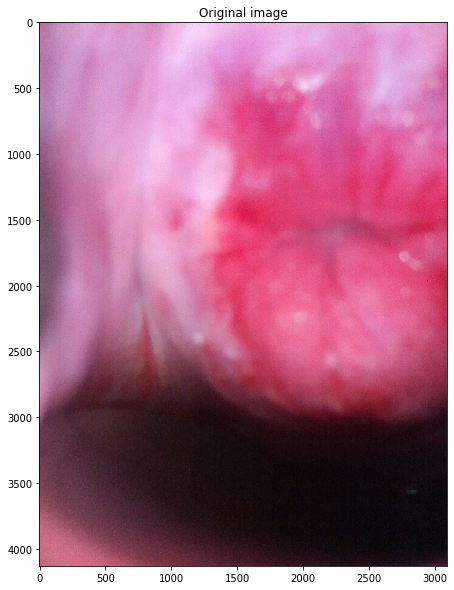

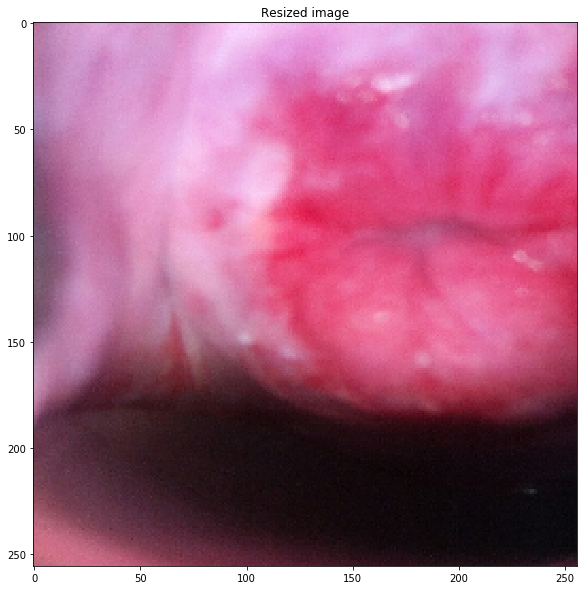

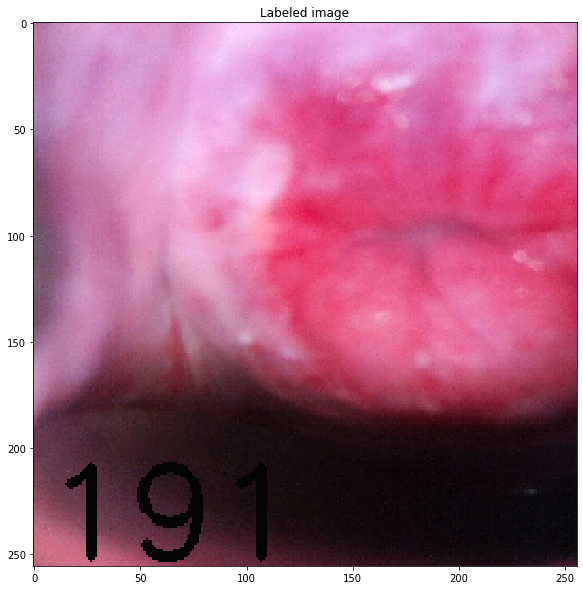

In [78]:
img = get_image_data(191, "Type1") 
plt_st(10, 10)
plt.imshow(img)
plt.title("Original image")

img = cv2.resize(img, dsize=(256,256))
plt_st(10, 10)
plt.imshow(img)
plt.title("Resized image")

img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (4, 4, 5), thickness=3)
plt_st(10, 10)
plt.imshow(img)
plt.title("Labeled image")

Display all train images across labels, from this notebook: https://www.kaggle.com/vfdev5/data-exploration-1

k:  0
type ids:  ['201' '215' '229' '205' '239' '262' '248' '265' '267' '298' '281' '294'
 '254' '245' '252' '208' '237' '191' '230' '218']
m:  2
train_ids ['191', '201', '205', '208', '215', '218', '229', '230', '237', '239', '245', '248', '252', '254', '262', '265', '267', '281', '294', '298']
k:  1
type ids:  ['60' '65' '64' '66' '39' '36' '37' '32' '31' '42' '56' '43' '40' '54'
 '44' '45' '51' '53' '52' '46']
m:  2
train_ids ['31', '32', '36', '37', '39', '40', '42', '43', '44', '45', '46', '51', '52', '53', '54', '56', '60', '64', '65', '66']
k:  2
type ids:  ['163' '188' '174' '170' '158' '172' '166' '135' '132' '143' '154' '141'
 '155' '169' '145' '179' '150' '187' '193' '146']
m:  2
train_ids ['132', '135', '141', '143', '145', '146', '150', '154', '155', '158', '163', '166', '169', '170', '172', '174', '179', '187', '188', '193']


Text(0.5, 1.0, 'Training dataset of type 1')

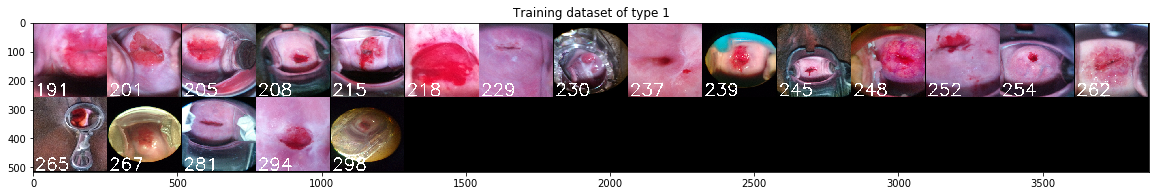

In [79]:
type_1_files = glob(os.path.join(basepath, "Type1", "*.jpg"))
type_1_ids = np.array([s[len(os.path.join(basepath, "Type1"))+1:-4] for s in type_1_files])
type_2_files = glob(os.path.join(basepath, "Type2", "*.jpg"))
type_2_ids = np.array([s[len(os.path.join(basepath, "Type2"))+1:-4] for s in type_2_files])
type_3_files = glob(os.path.join(basepath, "Type3", "*.jpg"))
type_3_ids = np.array([s[len(os.path.join(basepath, "Type3"))+1:-4] for s in type_3_files])

tile_size = (256, 256)
n = 15

complete_images = []
for k, type_ids in enumerate([type_1_ids, type_2_ids, type_3_ids]):
    print("k: ",k)
    print("type ids: ",type_ids)
    m = int(np.ceil(len(type_ids) * 1.0 / n))
    print("m: ",m)# 2
    complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)
        # np.zeros(12, 105, 3)
    train_ids = sorted(type_ids)
    print("train_ids",train_ids)
    counter = 0
    
    for i in range(m):
        ys = i*(tile_size[1] + 2)
        ye = ys + tile_size[1]
        for j in range(n):
            xs = j*(tile_size[0] + 2)
            xe = xs + tile_size[0]
            if counter == len(train_ids):
                break
            image_id = train_ids[counter]; counter+=1
            img = get_image_data(image_id, 'Type%i' % (k+1))
            img = cv2.resize(img, dsize=tile_size)
            img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 2.0,
                              (255, 255, 255) # text colour!
                              , thickness=3)
            complete_image[ys:ye, xs:xe, :] = img[:,:,:]
        if counter == len(train_ids):
            break
    complete_images.append(complete_image) 
plt_st(20, 20)
plt.imshow(complete_images[0])
plt.title("Training dataset of type 1")

Text(0.5, 1.0, 'Training dataset of type 1')

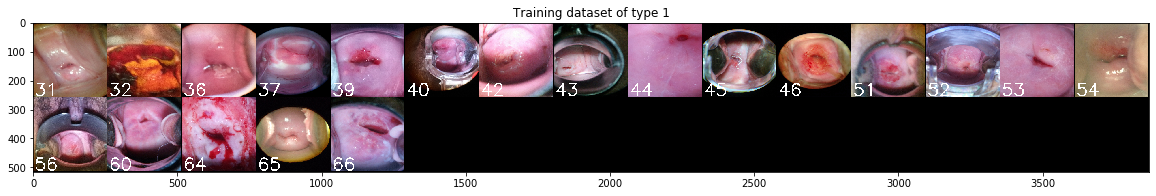

In [80]:
plt_st(20, 20)
plt.imshow(complete_images[1])
plt.title("Training dataset of type 2")

Text(0.5, 1.0, 'Training dataset of type 1')

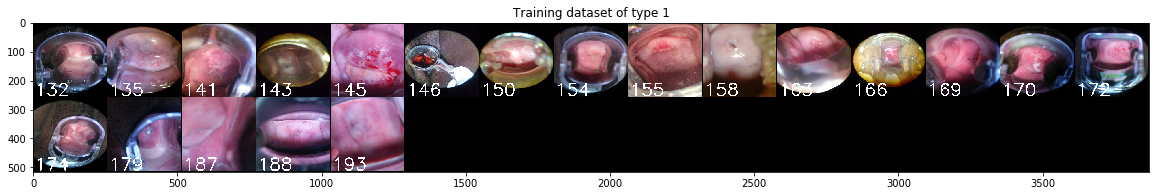

In [81]:
plt_st(20, 20)
plt.imshow(complete_images[2])
plt.title("Training dataset of type 3")